# Preprocessing for Topic Modeling

In [37]:
!pip install gensim


In [38]:


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim import corpora

nltk_data_path = "C:/Users/Hp/Customer Satisfaction Prediction/notebooks/nltk_data"
nltk.data.path.append(nltk_data_path)


nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path) 
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)


df = pd.read_csv("../data/processed/sentiment_scored_tickets.csv")

#  Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

#  Tokenizer Function
def preprocess_for_lda(text):
    try:
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha()]  # Remove punctuation/numbers
        tokens = [t for t in tokens if t not in stop_words]
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        return tokens
    except Exception as e:
        print(" Tokenization failed:", e)
        return []


# Preprocessing function
def preprocess_for_lda(text):
    from nltk.tokenize import word_tokenize  # Ensure loaded from working env
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# Apply to entire DataFrame
df["tokens"] = df["Ticket Description"].astype(str).apply(preprocess_for_lda)


df.to_csv("../data/processed/tokens_for_lda.csv", index=False)


[nltk_data] Downloading package punkt to C:/Users/Hp/Customer
[nltk_data]     Satisfaction Prediction/notebooks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:/Users/Hp/Customer
[nltk_data]     Satisfaction Prediction/notebooks/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:/Users/Hp/Customer
[nltk_data]     Satisfaction Prediction/notebooks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:/Users/Hp/Customer
[nltk_data]     Satisfaction Prediction/notebooks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:/Users/Hp/Customer
[nltk_data]     Satisfaction Prediction/notebooks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
from nltk.tokenize import word_tokenize

test_text = "Hello there! This is a simple test sentence."
tokens = word_tokenize(test_text)
print(tokens)


['Hello', 'there', '!', 'This', 'is', 'a', 'simple', 'test', 'sentence', '.']


# Create Dictionary and Corpus



In [14]:
from gensim import corpora

# Dictionary maps every word to a unique ID
dictionary = corpora.Dictionary(df["tokens"])

# Corpus is the Bag-of-Words representation of each document
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]


# Train LDA Model

In [39]:
from gensim.models.ldamodel import LdaModel

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,  
    random_state=42,
    passes=10,
    per_word_topics=True
)


# Display Top Words per Topic


In [17]:
# Print top 10 words for each topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f" Topic {idx}: {topic}")


 Topic 0: 0.081*"issue" + 0.028*"time" + 0.028*"please" + 0.024*"fine" + 0.022*"facing" + 0.022*"network" + 0.022*"assist" + 0.019*"recently" + 0.015*"update" + 0.014*"updated"
 Topic 1: 0.043*"like" + 0.041*"please" + 0.036*"would" + 0.035*"issue" + 0.034*"assist" + 0.031*"account" + 0.028*"data" + 0.028*"ensure" + 0.028*"safe" + 0.028*"security"
 Topic 2: 0.064*"please" + 0.059*"issue" + 0.038*"assist" + 0.023*"device" + 0.022*"problem" + 0.018*"made" + 0.015*"software" + 0.015*"unable" + 0.014*"screen" + 0.014*"update"
 Topic 3: 0.089*"issue" + 0.065*"please" + 0.048*"assist" + 0.027*"product" + 0.023*"persists" + 0.021*"tried" + 0.020*"need" + 0.014*"step" + 0.013*"troubleshooting" + 0.013*"work"
 Topic 4: 0.038*"issue" + 0.036*"software" + 0.031*"reset" + 0.030*"update" + 0.030*"resolve" + 0.025*"data" + 0.025*"problem" + 0.024*"help" + 0.023*"would" + 0.023*"please"


# Assign Dominant Topic to Each Ticket


In [40]:
def get_dominant_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    if topics:
        return sorted(topics, key=lambda x: -x[1])[0][0]
    return None

# Apply to all tickets
df["Dominant_Topic"] = [get_dominant_topic(lda_model, doc) for doc in corpus]


df.to_csv("../data/processed/tickets_with_topics.csv", index=False)


C:\Users\Hp\AppData\Local\Temp\ipykernel_25276\3417306282.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Dominant_Topic", data=df, palette="tab10")


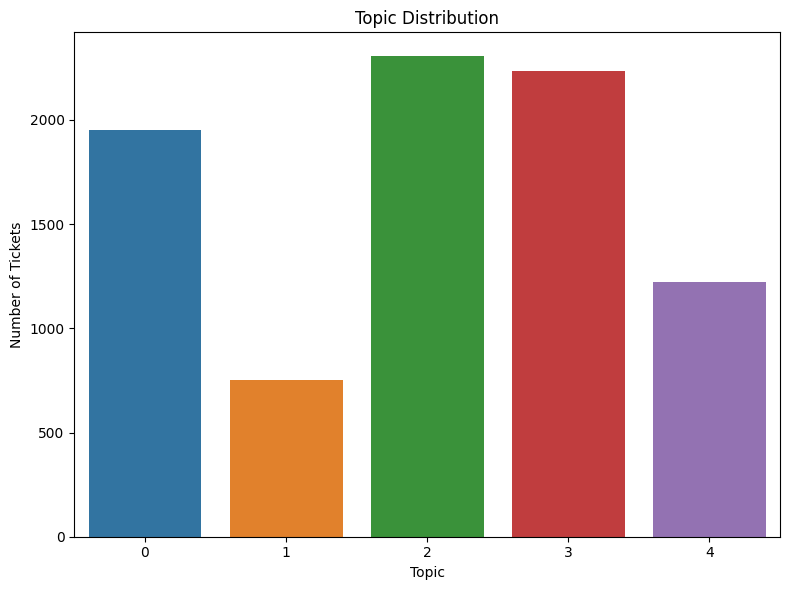

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x="Dominant_Topic", data=df, palette="tab10")
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Number of Tickets")
plt.tight_layout()
plt.show()


In [28]:
# Top words per topic
top_words_per_topic = []

for i in range(lda_model.num_topics):
    words = lda_model.show_topic(i, topn=10)
    topic_keywords = [word for word, prob in words]
    top_words_per_topic.append((i, ", ".join(topic_keywords)))

# Convert to DataFrame
topics_df = pd.DataFrame(top_words_per_topic, columns=["Topic", "Top Keywords"])
print(topics_df)


   Topic                                       Top Keywords
0      0  issue, time, please, fine, facing, network, as...
1      1  like, please, would, issue, assist, account, d...
2      2  please, issue, assist, device, problem, made, ...
3      3  issue, please, assist, product, persists, trie...
4      4  issue, software, reset, update, resolve, data,...


In [30]:
!pip install tabulate


In [31]:
from tabulate import tabulate

print(tabulate(topics_df, headers="keys", tablefmt="github"))


|    |   Topic | Top Keywords                                                                       |
|----|---------|------------------------------------------------------------------------------------|
|  0 |       0 | issue, time, please, fine, facing, network, assist, recently, update, updated      |
|  1 |       1 | like, please, would, issue, assist, account, data, ensure, safe, security          |
|  2 |       2 | please, issue, assist, device, problem, made, software, unable, screen, update     |
|  3 |       3 | issue, please, assist, product, persists, tried, need, step, troubleshooting, work |
|  4 |       4 | issue, software, reset, update, resolve, data, problem, help, would, please        |


In [32]:
# Replace with your actual interpretations
topic_labels = {
    0: "Late Delivery",
    1: "Payment/Refund Issues",
    2: "Product Quality",
    3: "Customer Support",
    4: "Account/Login Problems"
}


In [33]:
df["Topic_Label"] = df["Dominant_Topic"].map(topic_labels)


C:\Users\Hp\AppData\Local\Temp\ipykernel_25276\2588318293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Topic_Label", data=df, order=df["Topic_Label"].value_counts().index, palette="Set2")


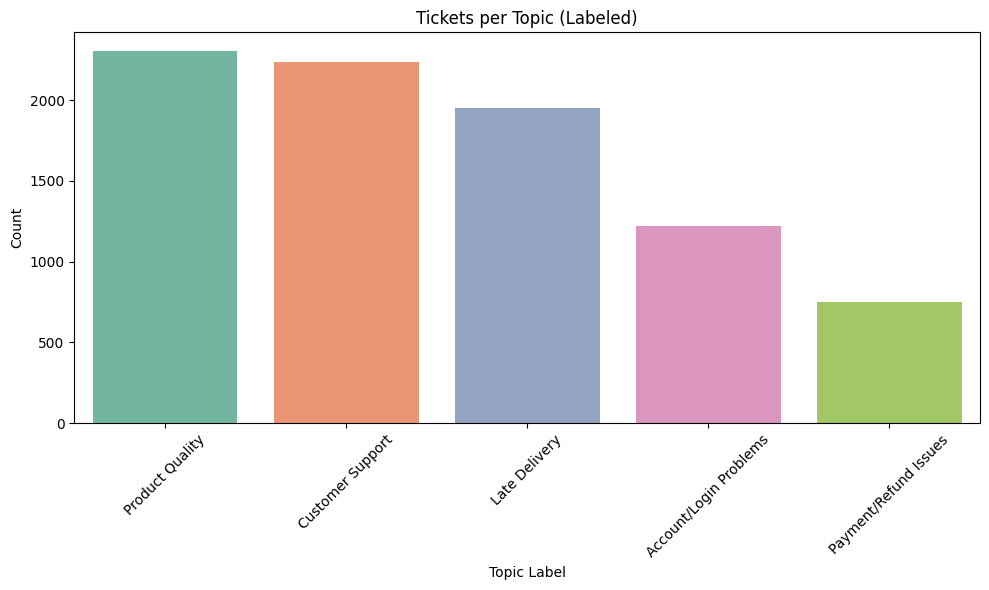

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Topic_Label", data=df, order=df["Topic_Label"].value_counts().index, palette="Set2")
plt.title("Tickets per Topic (Labeled)")
plt.xlabel("Topic Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
df.to_csv("../data/processed/topic_labeled_tickets.csv", index=False)
